## 一、接受-拒绝采样

### 1. $Acceptance$-$Rejection$ $Sampling$

$\Rightarrow Background: 目标分布P形式复杂，无法直接采样，因此引入一个易采样的辅助分布Q，通过蒙特卡罗法随机近似，间接对P采样$

$\Rightarrow Method:$

$$\begin{equation}\begin{aligned}
& ① 接受\mathrm{-}拒绝采样法通过在辅助分布Q上随机采样，对于给定的正常数M，采样点z需满足：\\
&\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad \forall z, M\cdot Q(z)\ge P(z)\\
& ② 定义每个样本点的接受率因子：\alpha(z) = \cfrac{P(z)}{M\cdot Q(z)}，0 \le \alpha(z) \le 1，则采样过程如下：\\
& ③ 每轮从Q中采样得到一个样本点z，再从0到1的均匀分布U(0,1)中随机采样一个值u，若u\le \alpha(z)，则接受z，否则丢弃\\
& ④ 重复③，直到接受足够多的N个样本点，这些样本点就近似服从目标分布
\end{aligned}\end{equation}$$

$\Rightarrow Limitation: 这种采样方法的效率非常依赖辅助分布Q，Q比较接近P，接受率才高，无效的采样次数才少，现实中一般不采用该法$

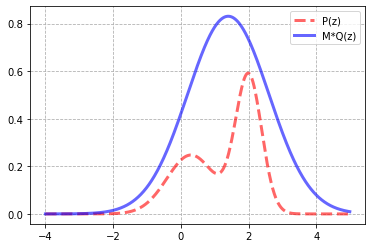

In [2]:
## target distribution and helper distribution
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# taget distribution pdf
def P(z):
    return (0.3 * np.exp(-(z-0.3)**2) + 0.7 * np.exp(-(z-2.0)**2/0.3)) / 1.2113
# helper distribution pdf
def Q(z):
    return norm(loc=1.4,scale=1.2).pdf(z)

M = 2.5
z = np.arange(-4.0,5.0,0.01)
plt.plot(z,P(z),color='r',lw=3,alpha=0.6,label='P(z)',ls='--')
plt.plot(z,M*Q(z),color='b',lw=3,alpha=0.6,label='M*Q(z)')
plt.legend()
plt.grid(ls='--')
plt.show()

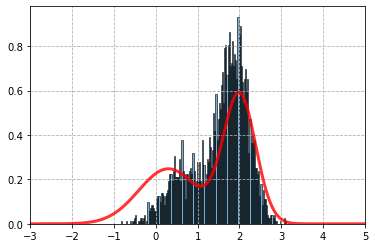

In [3]:
## Acceptance-Rejection Sampling example
from scipy.stats import uniform,norm

plt.clf()

uniform_rv = uniform(loc=0,scale=1) # U(0,1)
norm_rv = norm(loc=1.4,scale=1.2) # N(1.4,1.2^2)
Z = []
n = int(1e5)

for i in range(n):
    z = norm_rv.rvs(1)[0]
    u = uniform_rv.rvs(1)[0]
    alpha = P(z)/M*Q(z) # acceptance ratio
    if u <= alpha: # accepted
        Z.append(z)
    
x = np.arange(-3.,5.,0.01)
plt.gca().axes.set_xlim(-3,5)
plt.plot(x,P(x),lw=3,color='r',alpha=0.8)
plt.hist(Z,alpha=0.6,bins=150,density=True,edgecolor='k')
plt.grid(ls='--')
plt.show()

## 二、重要性采样

### 1. $\mathrm{MCMC}$ $($ $Markov$ $Chain$ $Monte$ $Carlo$ $)$

$\Rightarrow Background: 目标分布P形式复杂，无法直接采样，因此寻找一条马尔科夫链C，使得P恰为C的唯一稳态分布\\
在该马尔科夫链上随机游走，经过燃烧期t_{1\sim m}进入稳态后，再游走n次，收集t_{m+1\sim m+n}各时刻的样本x_{1\sim n}，该样本集即为P的近似采样$

In [5]:
## MCMC example
import numpy as np
from scipy.stats import uniform

def random_walk(state,P):
    u = uniform().rvs(1)[0]
    
    if u <= P[state][0]:
        return 0
    elif u <= P[state][0] + P[state][1]:
        return 1
    else:
        return 2

# target distribution
target = np.array([0.3888,0.2777,0.3333])
# state transform matrix => stable state follows target distribution: xP = x
P = np.array([
    [0.7,0.1,0.2],
    [0.3,0.5,0.2],
    [0.1,0.3,0.6],
],dtype=np.float)

m = int(1e4) # burning period
n = int(1e5) # sampling number in stable period

state = np.random.choice([0,1,2]) # init state
walk_steps = []

for i in range(m+n): # walk through both burning period and stable period
    walk_steps.append(state)
    state = random_walk(state,P)
    
# get the sampling and the approximate distribution
sampling = np.array(walk_steps[m:])
approx = np.array([
    np.sum(sampling == 0),
    np.sum(sampling == 1),
    np.sum(sampling == 2)
]) / len(sampling)

# compare the approximate distribution with the target
print("The target distribution is: {}".format(target))
print("The approximate distribution is : {}".format(approx))

The target distribution is: [0.3888 0.2777 0.3333]
The approximate distribution is : [0.39009 0.2807  0.32921]


### 2. $Metropolis$-$Hastings$ $Sampling$

$\Rightarrow Background: 1中与目标分布对应的马尔科夫链C并不容易找到，因为对于稳态分布\pi，C的状态转移矩阵P需要满足细致平稳条件，即：$

$$
P^T\pi = \pi \iff \pi_i\cdot P_{ij} = \pi_j\cdot P_{ji}, \forall i,j \in \{1,2,..,n\}
$$

$\Rightarrow Method: $

$因此，\mathrm{M}\mathrm{-}\mathrm{H}采样法对于任选的一个状态转移矩阵Q，类似接受\mathrm{-}拒绝采样，引入接受率因子：\alpha_{ij} = \min\left[1,\cfrac{\pi_j\cdot Q_{ji}}{\pi_i\cdot Q_{ij}}\right],\forall i,j \in \{1,2,..,n\}$

$利用接受率因子平衡等式，即可达到伪细致平稳条件：\alpha_{ij}\cdot\pi_i\cdot Q_{ij} = \alpha_{ji}\cdot\pi_j\cdot Q_{ji} = \min{\left[\pi_i\cdot Q_{ij},\pi_j\cdot Q_{ji}\right]}$

$\Rightarrow 对于接受率因子\alpha_{ij}的释义，可以理解当状态i以Q_{ij}的概率选择转移到状态j时，还有\alpha_{ij}的叠加概率选择是否接受这次转移，\\即有1-\alpha_{ij}的概率放弃转移，因此从状态i转移到状态j的概率修正为\alpha_{ij}\cdot Q_{ij}，而不发生转移的概率相应增加(1-\alpha_{ij})\cdot Q_{ij}$

$同时对于状态转移矩阵Q的选取，一般利用高斯分布的对称性：Q_{ij} = P(s_j|N(\mu = s_i,\sigma=1)) = P(s_i|N(\mu = s_j,\sigma=1)) = Q_{ji}$

$\Rightarrow 因此：\alpha_{ij} = \min\left[1,\cfrac{\pi_j\cdot Q_{ji}}{\pi_i\cdot Q_{ij}}\right] = \min\left[1,\cfrac{\pi_j}{\pi_i}\right]，节省计算代价$

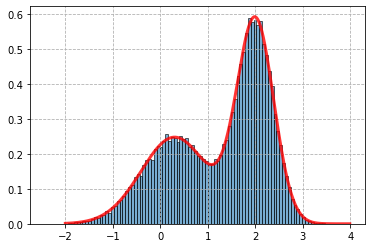

In [7]:
## M-H sampling example => the same example as A-R sampling
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm,uniform

plt.clf()

# taget distribution pdf
def P(z):
    return (0.3 * np.exp(-(z-0.3)**2) + 0.7 * np.exp(-(z-2.0)**2/0.3)) / 1.2113

walk_steps = []

# random walk through both burning period and stable period
for t in range(m+n):
    if t == 0: # init state
        walk_steps.append(np.random.choice([0,1,2]))
    else: # state transform
        last_state = walk_steps[-1]
        new_state = norm.rvs(loc=last_state,scale=1,size=1)[0] # sampling the next state
        alpha = min(1,P(new_state)/P(last_state)) # calculate the acceptance ratio
        u = uniform().rvs(1)[0]
        if u <= alpha: # accepted
            walk_steps.append(new_state)
        else: # rejected
            walk_steps.append(last_state)
            
sampling = walk_steps[m:]
            
x = np.arange(-2.,4.,0.01)
# target distribution
plt.plot(x,P(x),color='r',lw=3,alpha=0.8)
# approximate distribution by sampling
plt.hist(sampling,bins=100,density=True,edgecolor='k',alpha=0.6)
plt.grid(ls='--')
plt.show()

### 3. $Gibbs$ $Sampling$

$\Rightarrow Background: Gibbs采样法是一种针对高维分布的采样方法，即：\\假设待采样目标分布为m维分布p(X_1,X_2,..,X_m)，采样目标为一组m维向量的样本：\vec x^{(1)},\vec x^{(2)},..,\vec x^{(n)}$

$\Rightarrow Method: $

$$\begin{equation}\begin{aligned}
& ① 对于第t个时刻采得的样本向量\vec x^{(t)}，令\vec x^{(t)}_i是其第i维的属性\\
& ② 而Gibbs的思想为：对于\vec x^{(t)}，逐维地进行采样，即：\\
&\quad\quad\quad\quad\begin{cases}\vec x^{(t)}_1 \sim p(\vec x_1 | \vec x^{(t-1)}_{2\sim m})， \\
\vec x^{(t)}_2 \sim p(\vec x_2 | \vec x^{(t)}_1,\vec x^{(t-1)}_{3\sim m}) \\
\vec x^{(t)}_3 \sim p(\vec x_3 | \vec x^{(t)}_1,\vec x^{(t)}_2,\vec x^{(t-1)}_{4\sim m}) \\
...
\end{cases} \Rightarrow \vec x^{(t)}_i \sim p(\vec x_i | \vec x^{(t)}_{1\sim i-1},\vec x^{(t-1)}_{i+1\sim m}) ,i=1\rightarrow m\\
& ③ 重复②，可以采样出n个样本向量\vec x^{(1)},\vec x^{(2)},..,\vec x^{(n)}，丢弃燃烧期的样本，剩余样本即近似服从目标高维分布\\
\end{aligned}\end{equation}$$

$\Rightarrow 本质上，Gibbs采样是\mathrm{M}\mathrm{-}\mathrm{H}采样的一种特殊情况：\\
令：Q_{t,t+1} = \pi(\vec x^{(t+1)}_i|\vec x^{(t)}_{1\sim i-1,i+1\sim m}),i=1\rightarrow m，即每次固定\vec x^{(t)}除第i维外的其余m-1维属性，单采\vec x^{(t+1)}的第i维属性\\ 
此时可以证明，接受率因子：
\alpha_{t,t+1} = \min\left[1,\cfrac{\pi_{t+1}\cdot Q_{t+1,t}}{\pi_{t}\cdot Q_{t,t+1}}\right]
= \min\left[1,\cfrac{\pi(\vec x^{(t+1)}_i)\cdot \pi(\vec x^{(t)}_i|\vec x^{(t+1)}_{1\sim i-1,i+1\sim m})}{\pi(\vec x^{(t)}_i)\cdot \pi(\vec x^{(t+1)}_i|\vec x^{(t)}_{1\sim i-1,i+1\sim m})}\right] =\min{\left[1,1\right]}= 1，因此必定能接受$

$\Rightarrow Limitation: Gibbs采样要求每个单属性x_i的满条件概率分布p(x_i|x_{1\sim i-1,i+1\sim m})易于计算和采样$

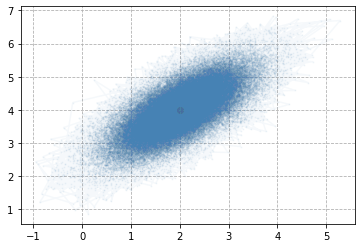

In [18]:
## Gibbs Sampling example => sampling 2d Gaussian Distribution

def condGD2d(x,mu,Sigma,reverse=False): # conditional 2d Gaussian Distribution p(x1|x2), or p(x2|x1) if reverse
    i,j = 0,1
    if reverse:
        i,j = 1,0
    
    cond_mu = mu[i] + Sigma[i][j]/Sigma[j][j]*(x[j]-mu[j])
    cond_Sigma = Sigma[i][i] - Sigma[i][j]/Sigma[j][j]*Sigma[j][i]
    
    return np.random.normal(cond_mu,cond_Sigma)

# target 2d Gaussian Distribution
target_mu = np.array([2,4])
target_Sigma = np.array([
    [1.,.7],
    [.7,1.]
])

# init
burning_period = int(1e4)
sampling_period = int(1e5)
walk_steps = np.zeros((burning_period+sampling_period,2))
x = np.zeros((2,))
x[1] = np.random.rand() * 10

# random walk through both burning period and stable/sampling period
for i in range(burning_period+sampling_period):
    # dimention-wise sampling
    x1 = condGD2d(x,target_mu,target_Sigma)
    x[0] = x1
    x2 = condGD2d(x,target_mu,target_Sigma,reverse=True)
    x[1] = x2
    walk_steps[i] = x
    
# show the sampling
sampling = walk_steps[burning_period:,:]
plt.scatter(target_mu[0],target_mu[1],c='r')
plt.plot(sampling[:,0],sampling[:,1],color='steelblue',marker='o',alpha=0.05,markersize=1)
plt.grid(ls='--')
plt.show()